In [64]:
import pandas as pd
import numpy as np
import pickle as pkl
from parameter_fit_scipy import flat_array_2_table
import plotly.express as px
import re
from glob import glob

results_dir = "results/fitting/scikit-opt/2024.08.21/"

def post_process_results():
    
    y_dfs = []
    x_dfs = []
    for file in glob(results_dir+"optim.yi_pm_*_pe_*.pkl"):
        yi = pkl.load(open(file, "rb"))
        p_mode, peer_eff = re.findall("pm_(.+)_pe_(.+).pkl", file)[0]
        df = pd.DataFrame(yi, index=range(len(yi)), columns=["value"])
        df[["p_mode","peer_eff"]] = float(p_mode), float(peer_eff)
        y_dfs.append(df)
    
    y_df = pd.concat(y_dfs)

    for file in glob(results_dir+"optim.Xi_pm_*_pe_*.pkl"):
        xi = pkl.load(open(file, "rb"))
        att_dfs = [flat_array_2_table(np.array(x)).melt(ignore_index=False) for x in xi]
        for i, df in enumerate(att_dfs):
            df["iteration"] = i
        att_df = pd.concat(att_dfs)
        # att_df["iteration"] = np.arange(len(att_df))//len(att_dfs[0])

        p_mode, peer_eff = re.findall("_pm_(.+)_pe_(.+).pkl", file)[0]
        att_df[["p_mode","peer_eff"]] = float(p_mode), float(peer_eff)
        x_dfs.append(att_df)
    
    x_df = pd.concat(x_dfs)
    return x_df, y_df



# Xi = pkl.load(open("optim.Xi_pm_0.75_pe_0.20.pkl", "rb"))

# px.line(flat_array_2_table(np.array(Xi[np.argmin(yi)])), template="plotly")
x_df, y_df = post_process_results()

In [65]:
# y_df.groupby(["p_mode","peer_eff"]).min().reset_index().pivot(columns="p_mode", index="peer_eff")

In [66]:
top_5 = y_df.reset_index(names=["iteration"]).groupby(["p_mode","peer_eff","iteration"]).min().sort_values(by="value").reset_index()

dupes = top_5[["p_mode","peer_eff"]].duplicated()
top_5 = top_5.loc[~dupes,:].head().set_index(["p_mode","peer_eff","iteration"])
top_5

,,,value
p_mode,peer_eff,iteration,
0.65,0.35,152,1.827956
0.80,0.30,156,1.859577
0.70,0.30,96,1.884261
0.80,0.25,141,1.886604
0.70,0.25,52,1.962189


In [67]:
x_df.reset_index().set_index(["p_mode","peer_eff","iteration"]).loc[top_5.index,:]

index                      variable     value
p_mode peer_eff iteration                                               
0.65   0.35     152         2000              Electric furnace  0.950000
                152         2001              Electric furnace  0.950000
                152         2002              Electric furnace  0.950000
                152         2003              Electric furnace  0.950000
                152         2004              Electric furnace  0.950000
...                          ...                           ...       ...
0.70   0.25     52          2016  Wood or wood pellets furnace  0.553784
                52          2017  Wood or wood pellets furnace  0.950000
                52          2018  Wood or wood pellets furnace  0.795716
                52          2019  Wood or wood pellets furnace  0.502344
                52          2020  Wood or wood pellets furnace  0.701604

[525 rows x 3 columns]

In [68]:
# plot_df = x_df.reset_index().query("iteration%15==0")
plot_df = x_df.reset_index().set_index(["p_mode","peer_eff","iteration"]).loc[top_5.index,:]
fig = px.line(
    plot_df.reset_index(),
    x="index",
    y="value",
    color="variable",
    facet_col="p_mode",
    facet_row="peer_eff",
    # line_dash="iteration",
    template="plotly",
    height=700,
    category_orders={
        "p_mode": sorted(plot_df.reset_index().p_mode.unique()),
    },
)  # "gut":asc_gut})

fig.update_traces(
    opacity=0.2,
)
fig.update_layout(yaxis_title="Mode")
fig.write_html(f"{results_dir}/fitted_att_modes.html")
fig

In [69]:
model_format_df = plot_df.drop("iteration").reset_index().pivot(columns="variable", index=["p_mode","peer_eff","index"],values="value")

In [71]:
p_mode, peer_eff,_ = top_5.index[-1]
p_mode, peer_eff

(0.7, 0.25)

In [72]:
att_modes = model_format_df.loc[(p_mode, peer_eff),:]
att_modes

variable,Electric furnace,Gas furnace,Heat pump,Oil furnace,Wood or wood pellets furnace
index,,,,,
2000,0.585239,0.050000,0.588027,0.471438,0.050000
2001,0.895224,0.150326,0.253241,0.739246,0.577891
2002,0.516529,0.894672,0.242740,0.760815,0.050000
2003,0.728534,0.118788,0.050000,0.635487,0.305062
2004,0.772549,0.364093,0.514306,0.854667,0.805211
2005,0.932728,0.165057,0.212727,0.507624,0.516100
2006,0.205018,0.795803,0.817242,0.937935,0.396037
2007,0.696772,0.050000,0.498850,0.178869,0.950000
2008,0.354582,0.323995,0.149203,0.950000,0.111448


In [73]:
from batch import BatchResult
province = "Ontario"
N = 500


batch_parameters = {
    "N": [N],
    "province": [province],
    "random_seed": range(20, 25),
    "start_year": 2000,
    "tech_att_mode_table": [att_modes],
    "n_segregation_steps": [40],
    "interact": [False],
    "price_weight_mode": [p_mode],
    "ts_step_length": ["W"],
    "peer_effect_weight": [peer_eff],
}
b_result = BatchResult.from_parameters(batch_parameters, display_progress=False)

In [79]:
model_tech_shares = b_result.tech_shares_df.drop("province", axis=1).melt(id_vars=["RunId","year",])
model_tech_shares

,RunId,year,variable,value
0,3,2000.00,Gas furnace,0.698
1,3,2000.25,Gas furnace,0.700
2,3,2000.50,Gas furnace,0.696
3,3,2000.75,Gas furnace,0.696
4,3,2001.00,Gas furnace,0.690
...,...,...,...,...
2020,2,2019.00,Heat pump,0.154
2021,2,2019.25,Heat pump,0.154
2022,2,2019.50,Heat pump,0.164
2023,2,2019.75,Heat pump,0.170


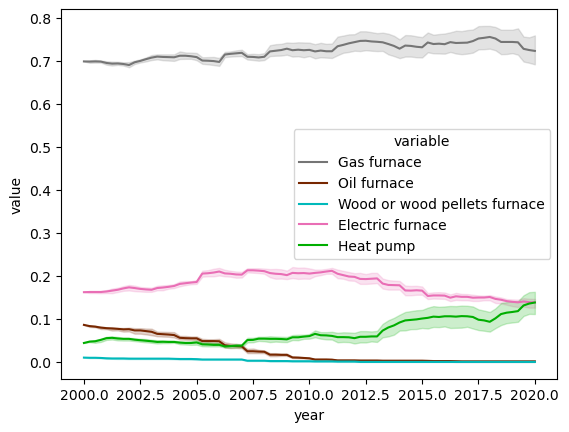

In [80]:
from data.canada import nrcan_tech_shares_df
from config import TECHNOLOGY_COLORS
import seaborn as sns
ontario_tech_shares = nrcan_tech_shares_df.loc[:,"Ontario",:]/100

ax = sns.lineplot(model_tech_shares, x="year", y="value", hue="variable", palette=TECHNOLOGY_COLORS)

In [81]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import config
added_historic_traces=False
historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
if not added_historic_traces:
    for tech in historic_tech_shares.columns:
        y = historic_tech_shares.loc[province, tech]/100
        added_historic_traces = True
        ax.plot(y.index,y.values, "--", color=config.TECHNOLOGY_COLORS[tech],)

# new_title = 'Heating technologies'
# ax.legend()


custom_lines = [Line2D([0], [0], linestyle="--", color="black", lw=1),
                Line2D([0], [0], color="black", lw=1),
                ]
ax.legend(custom_lines, ['historic', 'modelled'],)
ax.set_xticks(range(2000,2021,5), labels=range(2000,2021,5))

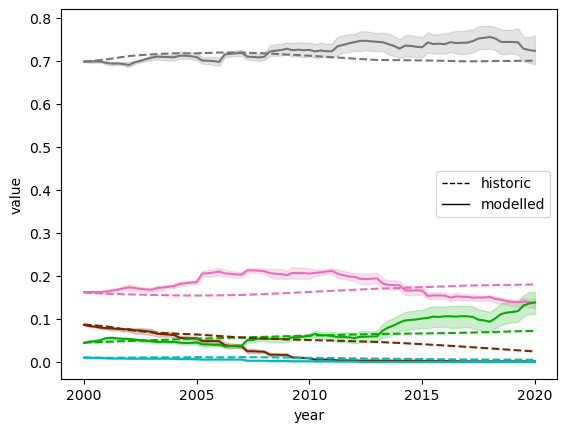

In [82]:
ax.figure